# Allen Institute
## 07-2_factor_analysis_gw9
---
### Dataset
- `../data/gse165388_processed/gw9_log.mtx`

1. Data Viz
2. Factor Analysis

In [1]:
import os
from itertools import product
import json
from typing import NamedTuple, Dict, Union

import factor_analyzer as fa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyreadr as pr
import seaborn as sns

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from tqdm.notebook import tqdm

from tools.factor_analysis import kmo_viz, parallel_analysis, plot_parallel_analysis, FactorAnalyzer
from tools.figure import boxplot, fa_preset, fig_kwarg, seurat
from tools.hdbscan_wrapper import HdbscanClustering, n_cluster
from tools.r import read_json
from tools.sklearn_wrapper import KMeansClustering
import tools.spongy_panda as spd

In [2]:
class Config(NamedTuple):
    data: pd.core.frame.DataFrame = spd.load_mtx(
        "../data/gse165388_processed/gw9_log.mtx",
        "../data/gse165388_processed/gw9_log.json",
        from_r = True
    ).loc[:, fa_preset].to_df()
    umap: pd.core.frame.DataFrame = pr.read_r(
        "../data/gse165388_annot/gw9umap.rds"
    )[None]
    sample_id: str = "gw9"
    save_dir: str = "../out/gse165388/07_fa_gw9"
    fig_kwarg: Dict[str, Union[str, int, float]] = fig_kwarg
    save_file: bool = False

In [3]:
conf = Config(save_file=True)

os.makedirs(conf.save_dir, exist_ok=True)

---
## Data Visualization
- heatmap
- kmo
- histogram

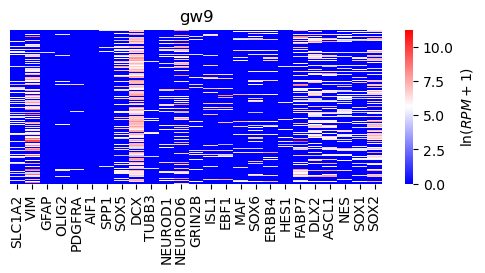

In [4]:
fig, ax = plt.subplots(figsize=(6, 2))
sns.heatmap(
    conf.data, ax=ax, cmap="bwr",
    vmax=conf.data.max().max(),
    vmin=conf.data.min().min(),
    yticklabels=False
)
ax.set(ylabel="", title=conf.sample_id)
ax.collections[0].colorbar.set_label("$\ln(RPM+1)$");

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/heatmap.png", **conf.fig_kwarg)

In [5]:
data = conf.data.loc[:, conf.data.columns[conf.data.max() > 0]]

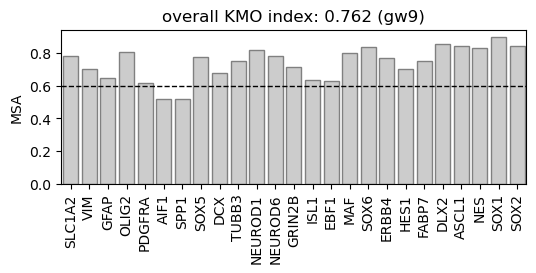

In [6]:
fig, ax = plt.subplots(figsize=(6, 2))

kmo_viz(data, ax=ax, line=True, landscape=True, **{"color": ".8"})

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(title=ax.get_title() + f" ({conf.sample_id})")

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/kmo.png", **conf.fig_kwarg)

In [7]:
conf = Config(
    data=data.T[fa.calculate_kmo(data)[0] > 0.6].T,
    save_file=conf.save_file
)

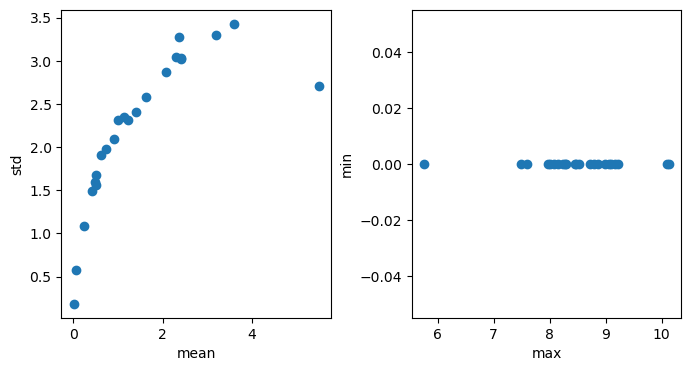

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plt.subplots_adjust(wspace=0.3)

ax[0].scatter(conf.data.mean(), conf.data.std())
ax[0].set(xlabel="mean", ylabel="std")

ax[1].scatter(conf.data.max(), conf.data.min())
ax[1].set(xlabel="max", ylabel="min");

- rescaling might not essential

---
## Factor Analysis
- parallel analysis
- factor analysis
- clustering

### Parallel Analysis

In [9]:
n_f = parallel_analysis(
    conf.data,
    random_state=0,
    nullmodel="perm",
    use_smc=True
)

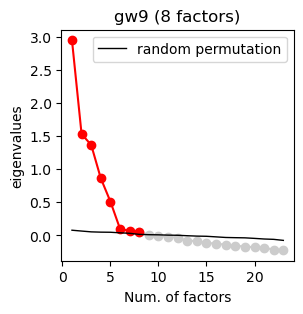

In [10]:
fig, ax = plt.subplots(figsize=(3, 3))

plot_parallel_analysis(
    conf.data,
    random_state=0,
    nullmodel="perm",
    use_smc=True,
    ax=ax
)

ax.set(title=f"{conf.sample_id} ({n_f} factors)")

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/pa.png", **conf.fig_kwarg)

### Factor Analysis
- quartimin rotation
- varimax rotation

In [11]:
rot, method = "quartimin", "ml"

In [12]:
model_fa = FactorAnalyzer(n_f, conf.data)

model_fa.rotate(rot, method)

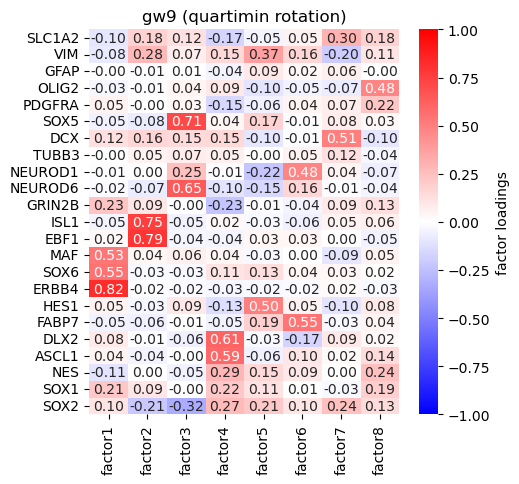

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))

model_fa.heatmap(ax)
ax.set(title=f"{conf.sample_id} ({rot} rotation)")

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/factors_{rot}_{n_f}.png", **conf.fig_kwarg)

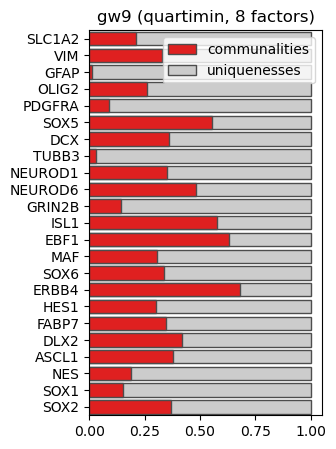

In [14]:
fig, ax = plt.subplots(figsize=(3, 5))

model_fa.plot_var(ax)
ax.set(title=f"{conf.sample_id} ({rot}, {n_f} factors)")

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/com_uni_{rot}_{n_f}.png", **conf.fig_kwarg)

- varimax rotation

In [15]:
rot = "varimax"

In [16]:
model_fa.rotate(rot, method)

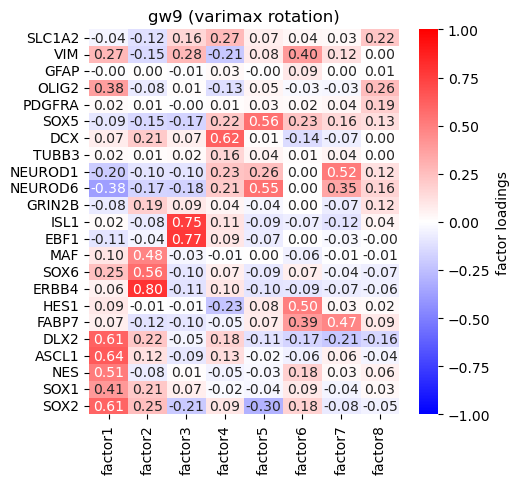

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))

model_fa.heatmap(ax)
ax.set(title=f"{conf.sample_id} ({rot} rotation)")

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/factors_{rot}_{n_f}.png", **conf.fig_kwarg)

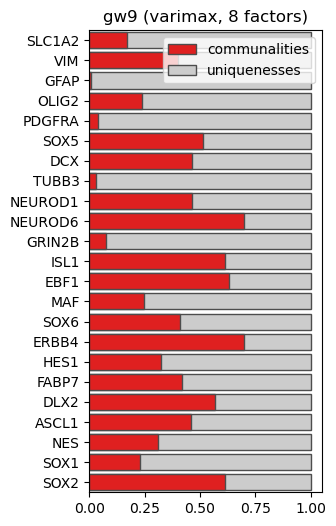

In [18]:
fig, ax = plt.subplots(figsize=(3, 6))

model_fa.plot_var(ax)
ax.set(title=f"{conf.sample_id} ({rot}, {n_f} factors)")

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/com_uni_{rot}_{n_f}.png", **conf.fig_kwarg)

### Comprehensive model selection

In [19]:
model_fa.results.keys()

dict_keys([(8, 'quartimin', 'ml'), (8, 'varimax', 'ml')])

In [20]:
res_fa = model_fa.results[(8, "quartimin", "ml")]

---
## Clustering

In [21]:
km = KMeansClustering(minimum=2, maximum=20, data=res_fa)

k-means:   0%|          | 0/19 [00:00<?, ?it/s]

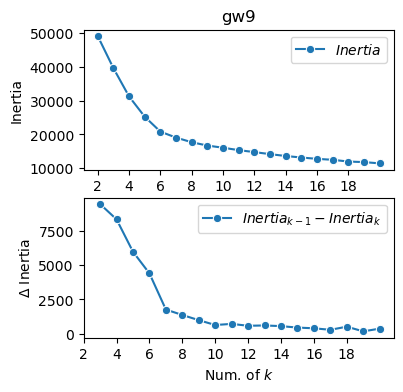

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4))

km.elbow(ax, show_diff=True)

ax[0].set(title=conf.sample_id)

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/elbow.png", **conf.fig_kwarg)

Calculating Silhouette Coeff.:   0%|          | 0/19 [00:00<?, ?it/s]

Calculating the mean:   0%|          | 0/19 [00:00<?, ?it/s]

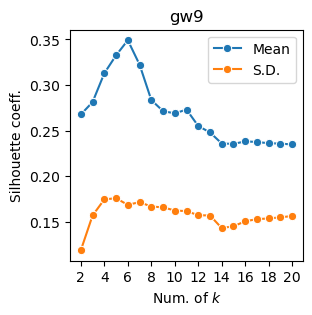

In [23]:
fig, ax = plt.subplots(figsize=(3, 3))

km.silhouette_curve(ax, show_diff=True)

ax.set(title=conf.sample_id)

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/silhouette_curve.png", **conf.fig_kwarg)

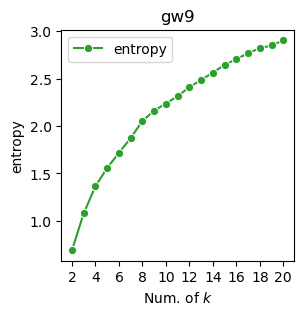

In [24]:
fig, ax = plt.subplots(figsize=(3, 3))

km.entropy_curve(ax, show_diff=True)

ax.set(title=conf.sample_id)

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/entropy.png", **conf.fig_kwarg)

### Choice of optimal k

In [25]:
km.optimal_k(manual=True, k=6)

Optimal Number of k: 6


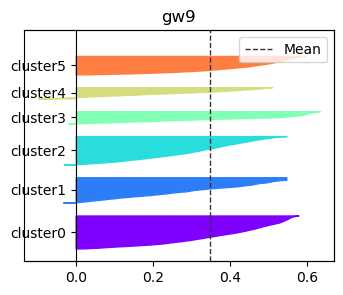

In [26]:
fig, ax = plt.subplots(figsize=(4, 3))

km.silhouette_plot(ax, cmap="rainbow")

ax.set(title=conf.sample_id)

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/silouhette_{km.k}.png", **conf.fig_kwarg)

### Visualization

In [27]:
center = conf.umap.assign(cluster=km.label.cluster.astype(str)).groupby("cluster").median()

In [28]:
kmlc = [f"{int(v)}" for v in km.label.cluster.sort_values()]

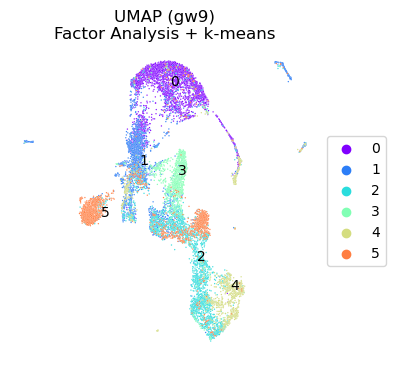

In [29]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(
    data=conf.umap.loc[km.label.cluster.sort_values().index, :],
    x="UMAP_1", y="UMAP_2", hue=kmlc,
    palette=km.cmap("rainbow"), ax=ax,
    s=1
)

for i, v in enumerate(center.index):
    ax.annotate("" if v == "Unclassifiable" else v, center.iloc[i, :])

ax.set(title=f"UMAP ({conf.sample_id})\nFactor Analysis + k-means")
ax.legend(bbox_to_anchor=(1, .5), loc="center left")
ax.axis("off");

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/{conf.sample_id}_umap.png", **conf.fig_kwarg)

Visualizing Factor Scores:   0%|          | 0/8 [00:00<?, ?it/s]

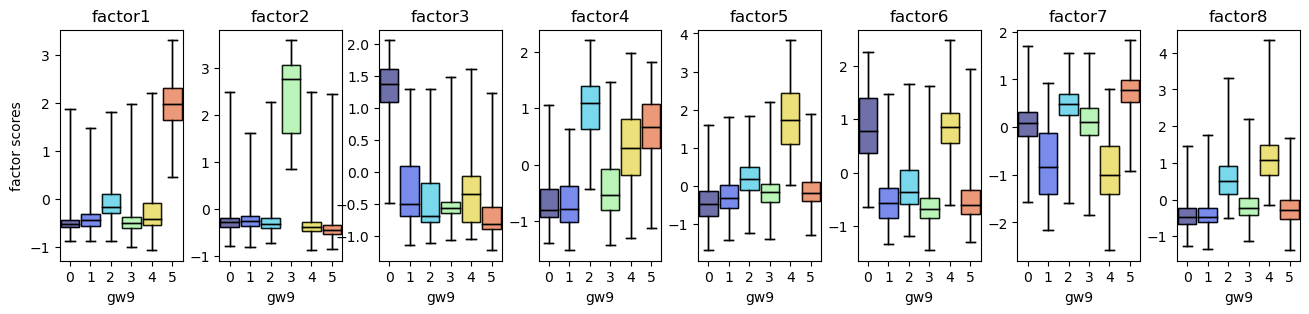

In [30]:
fig, ax = plt.subplots(1, n_f, figsize=(2 * n_f, 3))
plt.subplots_adjust(wspace=0.3)

kwargs = {"edgecolor": "k", "alpha": 0.6}

for i, v in tqdm(enumerate(km.data), desc="Visualizing Factor Scores", total=n_f):
    
    data = pd.concat([km.data.loc[:, v], km.label.cluster], axis = 1)
    
    boxplot(
        data=pd.concat([km.data, km.label.cluster], axis = 1),
        x="cluster",
        y=km.data.columns[i],
        palette=km.cmap("jet"),
        ax=ax[i],
        **kwargs
    )
    
    ax[i].set_ylabel("factor scores" if i == 0 else "")
    ax[i].set_xticklabels([k for k in range(km.k)]);
    ax[i].set(title=f"factor{i+1}", xlabel=conf.sample_id)
    
if conf.save_file:
    plt.savefig(f"{conf.save_dir}/facotrscores_{n_f}.png", **conf.fig_kwarg)

---
## Appendix: Clustering with HDBSCAN

In [31]:
hdb = HdbscanClustering(init=False)
hdb.grid_search(
    dict(
        min_cluster_size=np.arange(100, 300, 10),
        min_samples=np.arange(1, 15, 1)
    ),
    res_fa,
    n_jobs=-1
)

Grid Search:   0%|          | 0/14 [00:00<?, ?it/s]

{'min_cluster_size': 280, 'min_samples': 9}

In [32]:
hdb_cls = HdbscanClustering(init=False)
hdb_cls.grid_search(
    dict(
        min_cluster_size=np.arange(100, 300, 10),
        min_samples=np.arange(1, 15, 1)
    ),
    res_fa,
    objective=n_cluster,
    n_jobs=-1
)

Grid Search:   0%|          | 0/14 [00:00<?, ?it/s]

{'min_cluster_size': 100, 'min_samples': 4}

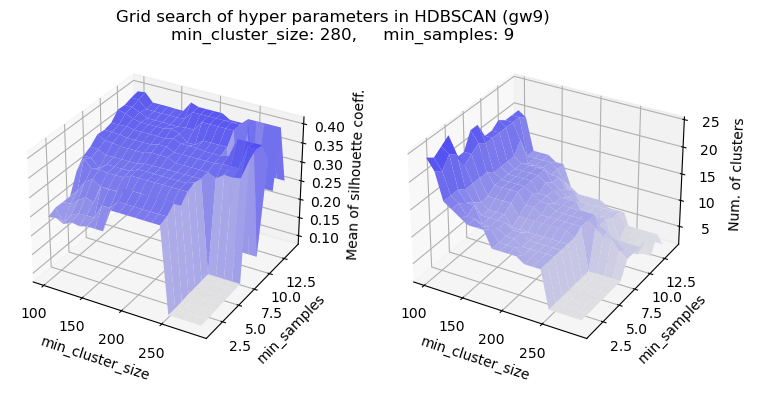

In [33]:
fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

ax1.plot_surface(**{**hdb.searcher.coordinate()[0]["args"]}, cmap=seurat)
ax2.plot_surface(**hdb_cls.searcher.coordinate()[0]["args"], cmap=seurat)

xlabel, ylabel = hdb.searcher.coordinate()[0]["X"], hdb.searcher.coordinate()[0]["Y"]

ax1.set(xlabel=xlabel, ylabel=ylabel, zlabel="Mean of silhouette coeff.")
ax2.set(xlabel=xlabel, ylabel=ylabel, zlabel="Num. of clusters");

fig.suptitle(
    f"Grid search of hyper parameters in HDBSCAN ({conf.sample_id})\
    \n{xlabel}: {hdb.searcher.best_params()[xlabel]}, \
    {ylabel}: {hdb.searcher.best_params()[ylabel]}"
)

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/grid_search.png", **conf.fig_kwarg)

In [34]:
cluster = pd.Series(
    [
        "Unclassifiable" if v == -1 else f"cluster{v}" for v in hdb.tune_fit_predict(res_fa)
    ],
    index=res_fa.index,
    name="cluster"
)

In [35]:
cmap = [
    seurat(0) if c == "Unclassifiable" else plt.cm.rainbow(
        i / len(cluster.unique())
    ) for i, c in enumerate(cluster.sort_values().unique())
]

In [36]:
center = conf.umap.assign(cluster=cluster).groupby("cluster").median()

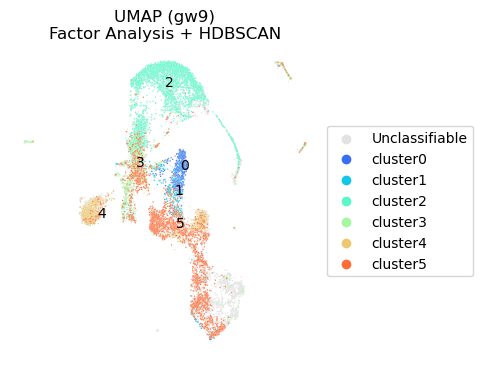

In [37]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(
    data=conf.umap.loc[cluster.sort_values().index, :],
    x="UMAP_1", y="UMAP_2", hue=cluster.sort_values(),
    palette=cmap, ax=ax,
    s=1
)

for i, v in enumerate(center.index):
    ax.annotate("" if v == "Unclassifiable" else v[-1], center.iloc[i, :])

ax.set(title=f"UMAP ({conf.sample_id})\nFactor Analysis + HDBSCAN")
ax.legend(bbox_to_anchor=(1, .5), loc="center left")
ax.axis("off");

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/{conf.sample_id}_umap_hdbscan.png", **conf.fig_kwarg)

---
## Export results

In [38]:
with open(f"{conf.save_dir}/colors_{km.k}.json", mode="w") as f:

    colors = {
        i: v for i, v in enumerate(km.cmap("jet"))
    }
    json.dump(colors, f)

In [39]:
res_cluster = km.label.assign(
    cluster_hdbscan = cluster
).loc[:, ["cluster", "cluster_hdbscan"]]

res_cluster.columns = ["cluster_id", "cluster_hdbscan"]

In [40]:
res_cluster.to_csv(f"../data/gse165388_annot/{conf.sample_id}_clusters_fa.csv", index=True)